# GeoML with Big Earth Net
https://torchgeo.readthedocs.io/en/stable/api/datasets.html#bigearthnet

In [2]:
import os
import torch # for model training
from torch import nn # for neural network layers
from torch.utils.data import RandomSampler, DataLoader
from torchvision.transforms import v2 as transforms
from torchgeo.models import resnet50 # import resnet50 model from torchvision
from torchgeo.models import ResNet50_Weights
from torchgeo.datasets import BigEarthNet


/home/isly9493/miniconda3/envs/pyt2/lib/python3.11/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/home/isly9493/miniconda3/envs/pyt2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Download and Visualize Big Earth Net Data

In [3]:
root = '/local/ms-data/bigearthnet'
dataset_train = BigEarthNet(root=root, split='train', bands='all', num_classes=19, transforms=None, download=False, checksum=False)
dataset_val = BigEarthNet(root=root, split='val', bands='all', num_classes=19, transforms=None, download=False, checksum=False)
dataset_test = BigEarthNet(root=root, split='test', bands='all', num_classes=19, transforms=None, download=False, checksum=False)

print(f'Dataset Classes: {dataset_train.class_sets}')
print(f'Number of images in train dataset: {len(dataset_train)}')
print(f'Number of images in validation dataset: {len(dataset_val)}')
print(f'Number of images in test dataset: {len(dataset_test)}')

Dataset Classes: {19: ['Urban fabric', 'Industrial or commercial units', 'Arable land', 'Permanent crops', 'Pastures', 'Complex cultivation patterns', 'Land principally occupied by agriculture, with significant areas of natural vegetation', 'Agro-forestry areas', 'Broad-leaved forest', 'Coniferous forest', 'Mixed forest', 'Natural grassland and sparsely vegetated areas', 'Moors, heathland and sclerophyllous vegetation', 'Transitional woodland, shrub', 'Beaches, dunes, sands', 'Inland wetlands', 'Coastal wetlands', 'Inland waters', 'Marine waters'], 43: ['Continuous urban fabric', 'Discontinuous urban fabric', 'Industrial or commercial units', 'Road and rail networks and associated land', 'Port areas', 'Airports', 'Mineral extraction sites', 'Dump sites', 'Construction sites', 'Green urban areas', 'Sport and leisure facilities', 'Non-irrigated arable land', 'Permanently irrigated land', 'Rice fields', 'Vineyards', 'Fruit trees and berry plantations', 'Olive groves', 'Pastures', 'Annual 

### Visualize Images and Labels from Each Dataset

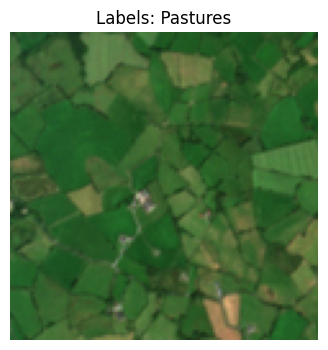

In [4]:
# visualize just one image
fig = dataset_train.plot(
    sample=dataset_train.__getitem__(0),
    show_titles=True
)

## 2. Train & Evaluate a Model Data 

1. Configure the GPU
1. Define the Train and Test Loos
1. Define a ResNet model with random weights, customize the model for the data
1. Define a data sampler and loader
1. Load and transform the data
1. Train & evaluate the model

#### Configure GPU

Note: there are additional steps required on Mac to use your processor as a GPU.

In [5]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


#### Define the Train & Test Loops

In [6]:
# train loop
# from the pytorch tutorial
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, sample in enumerate(dataloader):
        X, y = sample['image'], sample['label']
        X, y = X.to(device), y.float().to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # print intermediate results every n batches
        n = 5
        if batch % n == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [7]:
# test loop
# from the pytorch tutorial
def test(dataloader, model, loss_fn, val=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for sample in dataloader:
            X, y = sample['image'], sample['label']
            X, y = X.to(device), y.float().to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    prefix = "Validation" if val else "Test"
    print(f"{prefix} Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

#### Define the Dataloaders

In [8]:
def load_data(root, txs, batch_size=64):
    # todo: reimplement with a for loop over train, val, and test
    # reload data with the new transform
    dataset_train = BigEarthNet(root, split="train", transforms=txs)
    dataset_val = BigEarthNet(root, split="val", transforms=txs)
    dataset_test = BigEarthNet(root, split="test", transforms=txs)

    # define a dataloader to iterate over the dataset
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size)
    dataloader_val = DataLoader(dataset_val, batch_size=batch_size)
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size)
    
    return dataloader_train, dataloader_val, dataloader_test

#### Define Data Transforms

In [9]:
# Custom transform function to handle the dictionary structure of torchgeo dataset
class CustomTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, sample):
        sample['image'] = self.transform(sample['image'])
        return sample
    
# Define transformations for the dataset to get it 
transform = transforms.Resize((264, 264))  # Resizes the images to 224x224

custom_transform = CustomTransform(transform)

#### Define Train, Val, Test Function

In [10]:
def train_val_test(dataloader_train, dataloader_val, dataloader_test, model, loss_fn=nn.CrossEntropyLoss(), lr=1e-3, epochs=1):
    # create optimizer from the model and the learning rate
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    # # baseline before training
    # print(f"Baseline Before Training\n-------------------------------")
    # test(dataloader_test, model, loss_fn, val=False)
    # test(dataloader_val, model, loss_fn, val=True)

    # run train / val loop
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(dataloader_train, model, loss_fn, optimizer)
        test(dataloader_val, model, loss_fn, val=True)

    # test result with test data
    print("Test Results\n-------------------------------")
    test(dataloader_test, model, loss_fn, val=False)

    print("Training Complete!")

def evaluate_model(model, dataloader_test, loss_fn=nn.CrossEntropyLoss()):
    print(f"Evaluating Model on Test Data\n-------------------------------")
    test(dataloader_test, model, loss_fn, val=False)

#### Define a Function to Save Down the Model

In [11]:
def save_model(model, path, experiment_name):
    if not os.path.exists("models"):
        os.makedirs("models")
    model_weights_path = os.path.join("models", path, experiment_name)
    torch.save(model.state_dict(), model_weights_path)

#### Define the Model, Load Data, Run Train, Save Results

In [12]:
torch.manual_seed(42)
model = resnet50(weights=None, num_classes=19, in_chans=14).to(device)
dataloader_train, dataloader_val, dataloader_test = load_data('/local/ms-data/bigearthnet', custom_transform, batch_size=256)
train_val_test(dataloader_train, dataloader_val, dataloader_test, model, loss_fn=nn.CrossEntropyLoss(), lr=1e-3, epochs=1)
save_model(model, 'bigearthnet', "resnet50_epochs1.pth")

Epoch 1
-------------------------------
loss: 5.927715  [  256/269695]
loss: 6.672348  [ 1536/269695]
loss: 5.148941  [ 2816/269695]
loss: 3.995745  [ 4096/269695]
loss: 5.179402  [ 5376/269695]
loss: 6.241724  [ 6656/269695]
loss: 4.124465  [ 7936/269695]
loss: 5.526307  [ 9216/269695]
loss: 4.531586  [10496/269695]
loss: 4.373061  [11776/269695]
loss: 5.446622  [13056/269695]
loss: 4.586966  [14336/269695]
loss: 5.145950  [15616/269695]
loss: 10.366686  [16896/269695]
loss: 9.711892  [18176/269695]
loss: 9.551719  [19456/269695]
loss: 9.519094  [20736/269695]
loss: 9.918508  [22016/269695]
loss: 7.512750  [23296/269695]
loss: 9.571412  [24576/269695]
loss: 10.369514  [25856/269695]
loss: 7.088415  [27136/269695]
loss: 6.755465  [28416/269695]
loss: 5.922619  [29696/269695]
loss: 8.435254  [30976/269695]
loss: 7.607128  [32256/269695]
loss: 5.973084  [33536/269695]
loss: 6.930801  [34816/269695]
loss: 6.052696  [36096/269695]
loss: 5.226089  [37376/269695]
loss: 5.466524  [38656/26969

KeyboardInterrupt: 